In [1]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

input_mzml_files = sorted(glob.glob('results/interim/PCpeak_*.mzML'))

raw_data=[]
for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    raw_data.append(exp)

ref_index = [i[0] for i in sorted(enumerate([exp.size() for exp in raw_data]), key=lambda x:x[1])][-1]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
aligner_par.setValue("max_num_peaks_considered", 3000)
aligner.setParameters(aligner_par)
aligner.setReference(raw_data[ref_index])

for exp in raw_data[:ref_index] + raw_data[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(exp, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(exp, trafo, True)

for exp in raw_data:    
    mzml_file = os.path.join("results", "", "Requant", "", "interim", "", 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[7:-5] +".mzML")
    MzMLFile().store(mzml_file, exp)

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [4]:
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [2]:
import pandas as pd
import numpy as np
import os
import glob


In [1]:
import sys
sys.path.insert(0, '/Users/eeko/openms-develop/openMS-build/pyOpenMS')
from pyopenms import *

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [5]:
input_mzml_files=sorted(glob.glob("results/Requant/interim/*.mzML"))
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('resources/MetaboliteIdentification.tsv')

    params = ff.getParameters()
    params[b'extract:mz_window'] = 5.0 
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)
    # FeatureMap to store results
    fm = FeatureMap()
    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm) #, String(mzml_file)

    # save FeatureMap to file
    ff_file = os.path.join("results", "", "Requant", "", "interim", "", 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

In [9]:
from collections import defaultdict
from functools import reduce
from pathlib import Path
from time import perf_counter
import sys

from IPython.core.display import display
from pandas import CategoricalDtype 
import numpy as np
from pyopenms import *
import pandas as pd
import os

common_meta_value_types = {
    b'label': 'U30',
    b'spectrum_index': 'i',
    b'score_fit': 'f',
    b'score_correlation': 'f',
    b'FWHM': 'f',
    b'spectrum_native_id': 'U30',
    b"num_of_masstraces" : "f"
}

class FeatureMapDF(FeatureMap):
    def __init__(self):
        super().__init__()
    
    # meta_values = None (default), 'all' or list of meta value names
    def get_df(self, meta_values = None):
        # get all possible meta value keys in a set
        if meta_values == 'all':
            meta_values = set()
            for f in self:
                mvs = []
                f.getKeys(mvs)
                for m in mvs:
                    meta_values.add(m)
        elif not meta_values: # if None, set to empty list
            meta_values = []
        
        def gen(fmap: FeatureMap, fun):
            for f in fmap:
                yield from fun(f, meta_values)

        def extract_meta_data(f: Feature, meta_values):
            bb = f.getConvexHull().getBoundingBox2D()
                
            vals = [f.getMetaValue(m) if f.metaValueExists(m) else np.NA for m in meta_values]   # find some NA or None value for numpy

            yield f.getUniqueId(), f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getOverallQuality(), f.getIntensity()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('RTstart', 'f'), ('RTend', 'f'),
                    ('quality', 'f'), ('intensity', 'f')]
        
        for meta_value in meta_values:
            if meta_value in common_meta_value_types:
                mddtypes.append((meta_value.decode(), common_meta_value_types[meta_value]))
            else:
                mddtypes.append((meta_value.decode(), 'U50'))
        mdarr = np.fromiter(iter=gen(self, extract_meta_data), dtype=mddtypes, count=cnt)
        df= pd.DataFrame(mdarr).set_index('id').sort_values("mz")
        #df= df[df["num_of_masstraces"]>=2]
        return df

In [10]:
input_feature_files = sorted(glob.glob('results/Requant/interim/FFMI_*.featureXML'))

for filename in input_feature_files:
    fmap = FeatureMapDF()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "Requant", "", 'features_' +  os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[11:-5] +".csv")
    DF.to_csv(feature_csv)
    print(os.path.basename(filename))
    display(DF)

FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
6779460035304800368,1,64.865883,152.056168,57.401688,71.244118,2.771286,2.030070e+05
13943752185986203656,1,220.469421,152.070084,213.578094,228.373856,3.778659,3.782497e+04
12798573101193454331,1,64.865891,155.080963,57.401688,71.244118,4.814148,2.494702e+05
466348627699078712,1,105.925674,155.080978,98.692268,113.328033,4.803148,2.377574e+05
5681079727169575490,1,64.856339,157.096588,59.941105,71.244118,2.600025,4.599726e+04
...,...,...,...,...,...,...,...
5498814147990939282,3,57.570805,1482.843018,51.029140,58.682755,3.974073,1.321363e+05
4782236559612104679,3,65.550865,1483.177979,61.170502,73.740509,3.552404,2.490552e+05
8137237597188825654,2,56.711224,1485.514160,48.486141,62.378098,4.067296,6.274994e+05


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
9580361810607300402,1,61.796524,152.056168,54.532444,69.039505,2.660101,1.635787e+06
1198497665327712312,1,85.601051,153.040192,80.940842,90.342621,-4.545573,3.187437e+03
14561834521017206324,1,61.825218,155.080963,54.532444,69.039505,4.179129,2.525302e+05
1392807159208332361,1,61.232738,157.096588,53.253197,69.039505,0.950524,4.229514e+04
8719927500069282417,1,61.825600,158.091812,54.532444,69.039505,4.538174,3.799654e+05
...,...,...,...,...,...,...,...
4814547523342799275,3,56.009838,1482.843018,48.548748,58.175213,3.975889,2.401849e+05
3159795235816471004,3,59.875805,1483.177979,48.548748,70.226730,1.009578,1.584640e+06
14354688765166597198,2,63.236725,1485.509888,55.768665,72.628120,1.519182,2.749468e+05


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
16631819984683411351,1,62.811951,152.056168,49.346439,70.653336,-1.188549,5.306156e+05
10333694221330615184,1,62.429016,155.080963,54.053635,70.653336,0.801642,3.733375e+05
16229410317863518827,1,62.878349,157.096588,55.271957,70.653336,-1.087098,5.096590e+04
18102336719887476026,1,63.610992,158.091812,56.459919,70.653336,4.753535,1.335405e+06
6142326702565430919,1,61.138996,162.075531,56.459919,67.124756,2.600043,1.148447e+04
...,...,...,...,...,...,...,...
601536917955703349,3,53.886059,1482.843018,46.880306,57.631603,4.332985,1.931652e+05
929523135691242630,3,62.820671,1483.177979,58.790913,71.838341,1.175566,4.082835e+05
15377513462429554753,1,53.792782,1485.513306,45.683685,71.838341,4.490646,6.870470e+05


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
4457082044903100606,1,62.819027,152.056168,55.601650,70.924599,-0.489178,6.745913e+05
11545201938042436754,1,62.755798,155.080963,54.371895,70.924599,0.983868,3.569431e+05
1623565588752733518,1,63.087917,157.096588,49.596596,70.924599,-1.403492,6.126185e+04
18443193847274874810,1,63.945724,158.091812,56.793709,70.924599,4.817719,1.359200e+06
2836072547577924146,1,61.471943,159.075821,54.371895,68.579872,3.855956,1.440360e+04
...,...,...,...,...,...,...,...
15845654651104593015,3,54.616180,1482.843018,45.878464,57.974503,4.151319,2.438961e+05
4138099601033493660,3,61.955349,1483.177979,59.143669,70.924599,4.016490,2.642045e+05
123361193593044256,1,53.796528,1485.513306,45.353630,60.297253,4.366561,8.539974e+05


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
10501986910890670533,1,76.668869,152.056168,70.038185,83.563202,-0.714317,63872.921875
10017170544921371208,1,76.668869,153.040192,70.038185,83.563202,0.718985,46386.781250
328972505784321663,1,76.668869,155.080963,70.038185,83.563202,3.927770,288610.312500
14515988136619182668,1,108.674828,157.096588,97.213127,115.623474,-0.502543,16780.630859
2957058773634700330,1,76.668869,159.075821,70.038185,83.563202,-5.273870,16836.650391
...,...,...,...,...,...,...,...
886177190112447467,1,314.921997,1436.639893,306.372467,319.373596,4.631801,533971.125000
12421644993059546564,1,343.036316,1439.655029,336.556458,349.438293,4.450621,82004.179688
3998030992688502937,2,61.970745,1468.025269,55.558628,68.706024,4.105622,88924.882812


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
14535734867758414431,1,65.271606,152.056168,57.759121,72.500992,-0.715790,5.028852e+04
10981560254065738023,1,65.564285,155.080963,58.987076,72.500992,3.914337,3.624721e+05
1068887182519949302,1,90.565468,157.096588,82.564491,98.234344,2.676222,4.125428e+05
11834600824770007718,1,66.231392,158.091812,58.987076,73.728134,4.653351,8.104434e+07
1900758086231837955,1,66.308929,159.075821,58.987076,73.728134,-5.419951,2.846643e+05
...,...,...,...,...,...,...,...
14561428233947689103,1,56.457138,1477.499268,49.982040,63.783772,4.441930,2.611362e+04
7389927252518465532,1,334.970459,1478.690796,327.835968,342.948212,4.544922,2.358239e+05
18074234878768522188,1,307.280823,1482.685913,299.261749,315.450226,4.508982,6.675919e+05


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
16789306814714780121,1,92.343826,157.096588,83.903893,99.434624,1.826106,3.210958e+05
8834537332778033212,1,88.691330,158.091812,81.493248,95.819717,0.682457,6.292348e+03
14326329933390772374,1,46.743221,159.075821,44.608349,54.059418,0.440353,1.262439e+07
3715795213851147417,1,89.867195,160.075150,82.698051,97.031113,3.929026,2.381116e+04
8867476787641195633,1,263.975067,162.054398,256.602692,271.303284,-5.031426,5.856874e+03
...,...,...,...,...,...,...,...
10390352936354123557,1,56.654221,1477.499268,50.236275,64.003014,4.710239,1.777395e+04
6418296111903136924,1,331.815247,1478.690796,324.018921,340.802979,4.658881,5.161622e+05
2913765186909182465,1,302.115784,1482.685913,294.830688,309.914551,4.632221,7.187745e+05


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
17269659689178854975,1,85.384712,152.056168,78.020340,92.586342,-3.637487,3996.178223
5809707590369464690,1,89.985741,157.096588,82.942108,97.447098,2.203909,348607.906250
14160037957710950610,1,87.303947,158.091812,80.492325,93.799095,1.127181,22663.779297
2335977570800386694,1,63.183659,159.075821,56.475777,70.308060,-4.489877,400614.812500
6633848216543232212,1,87.606903,160.075150,81.719337,95.022324,0.768418,20309.750000
...,...,...,...,...,...,...,...
14580614737868965533,1,52.096916,1477.499390,44.998062,58.894459,4.397920,81196.218750
17895592221014712825,1,332.690796,1478.690796,324.891693,340.523865,4.525540,410834.593750
9270521273071441580,1,303.114105,1482.685913,295.292297,312.554382,4.494514,706590.875000


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
16396627219930094709,1,122.746582,153.040192,119.145386,126.332031,-6.301669,6.010127e+03
3633296983820309224,1,279.229797,159.091064,271.906616,286.712921,-1.952862,1.054678e+04
883698529788809879,1,293.015350,162.054428,289.203583,296.779877,-2.480797,1.722998e+04
1155640077440820363,1,72.500946,162.075531,65.660721,78.145721,-2.077015,3.233662e+04
5691694760947578745,1,60.492737,166.052673,54.345844,66.888725,-5.925615,2.313998e+04
...,...,...,...,...,...,...,...
2285525730395184048,3,60.768154,1483.177979,49.057377,69.320633,4.348362,1.316512e+05
11624318832175230017,2,61.062263,1485.509888,54.345844,68.120193,4.526611,5.920821e+05
7220954958848787224,1,53.584236,1485.513306,45.311016,55.603745,3.801116,5.438536e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
13827957299508051744,1,62.831272,152.056168,55.515396,70.156944,-1.779730,3.016066e+04
10177176204019348086,1,62.831360,155.080963,55.515396,70.156944,4.078637,1.934901e+05
2665139354868761074,1,62.831257,157.096588,55.515396,70.156944,4.051111,1.938711e+04
15553797221256980599,1,62.831272,158.091812,55.515396,70.156944,4.762939,1.776244e+06
15834760176572947576,1,292.991211,159.091064,285.836761,300.156616,-3.557896,6.691771e+03
...,...,...,...,...,...,...,...
11540701551856539020,3,52.647251,1482.843018,45.542580,55.515396,3.931542,4.255687e+04
7314053945385745425,3,60.831097,1483.177979,56.725086,68.949799,3.998992,8.815782e+04
6304223559691399761,2,63.283485,1485.509888,56.725086,71.362312,4.490026,4.659738e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
18305829263457869265,1,60.337032,152.056168,53.099388,67.737648,-1.755976,9.872725e+04
15851992003601902530,1,76.023224,153.040192,72.554497,83.347626,-3.420941,2.993516e+03
17074519437303712218,1,60.333485,155.080963,53.099388,67.737648,4.647839,1.883950e+05
14725209559210276962,1,60.336597,157.096588,53.099388,67.737648,4.007604,1.343551e+04
8440938669220168811,1,78.586952,158.091812,72.554497,84.534706,-1.250715,2.839973e+03
...,...,...,...,...,...,...,...
4403878866212871728,3,60.872658,1483.177979,56.783195,70.139503,4.030755,7.846965e+04
14440430011684610011,2,60.689110,1485.509888,53.099388,70.139503,4.696503,4.707206e+05
6982369948880004794,1,52.713772,1485.513306,44.017231,56.783195,3.881277,6.006521e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
17806343080640522621,1,61.236183,152.056168,54.287907,68.918221,-4.592659,9.799349e+04
1330555140745389982,1,95.550858,153.040192,88.074379,103.262917,-5.887690,5.471522e+03
1411516728387456180,1,61.294632,155.080963,53.027191,68.918221,0.699221,3.201624e+05
11970756054761642495,1,60.908886,157.096588,53.027191,68.918221,3.988412,2.442014e+04
16619539951047472698,1,62.848072,158.091812,55.533226,70.113480,4.760051,1.878474e+06
...,...,...,...,...,...,...,...
4262540228526693907,3,51.215118,1482.843018,44.377449,54.287907,1.518872,2.416276e+04
4032292776226716538,3,60.568966,1483.177979,53.027191,67.723534,4.583872,7.558447e+04
6643145562306594134,1,52.541622,1485.513306,44.377449,68.918221,4.069364,6.749305e+05


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

path= sorted(glob.glob('results/Requant/interim/*.featureXML'))

def plotDetectedFeatures3D(filename):
    fm = FeatureMap()
    fh = FeatureXMLFile()
    fh.load(filename, fm)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for feature in fm:
        color = next(ax._get_lines.prop_cycler)['color']
        # chromatogram data is stored in the subordinates of the feature
        for i, sub in enumerate(feature.getSubordinates()):
            retention_times = [x[0] for x in sub.getConvexHulls()[0].getHullPoints()]
            intensities = [int(y[1]) for y in sub.getConvexHulls()[0].getHullPoints()]
            mz = sub.getMetaValue('MZ')
            ax.plot(retention_times, intensities, zs = mz, zdir = 'x', color = color)
            if i == 0:
                ax.text(mz,retention_times[0], max(intensities)*1.02, feature.getMetaValue('label'), color = color)

    ax.set_ylabel('time (s)')
    ax.set_xlabel('m/z')
    ax.set_zlabel('intensity (cps)')
    plt.show()


results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


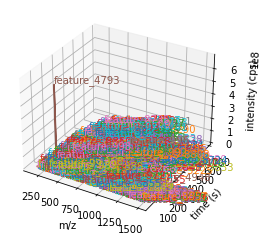

results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


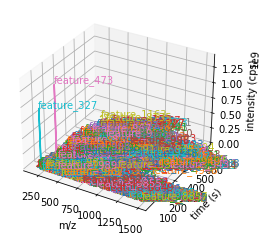

results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


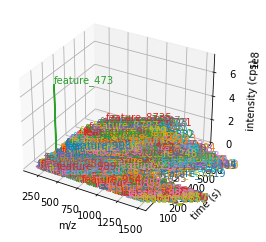

results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


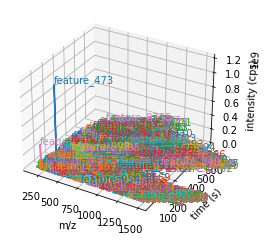

results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


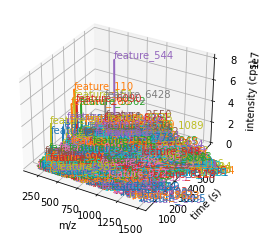

results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


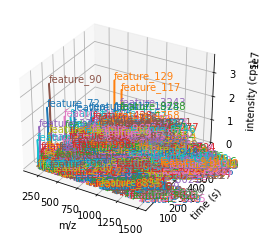

results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


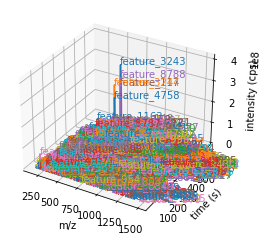

results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


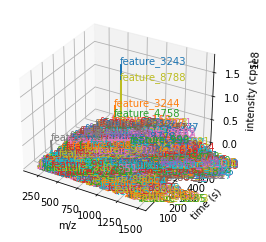

results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


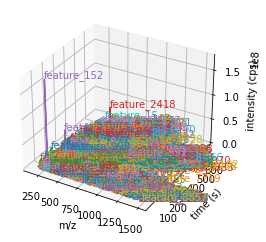

results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


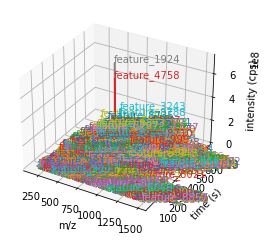

results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


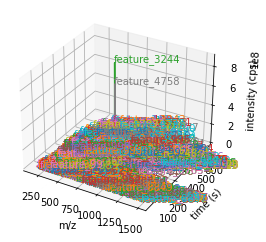

results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


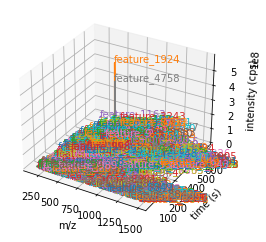

In [4]:
for filename in path:
    print(filename)
    plotDetectedFeatures3D(filename)

### Create a matrix for PCA

In [3]:
class ConsensusMapDF(ConsensusMap):
    def __init__(self):
        super().__init__()

    def get_intensity_df(self):
        labelfree = self.getExperimentType() == "label-free"
        filemeta = self.getColumnHeaders()  # type: dict[int, ColumnHeader]
        labels = list(set([header.label for header in
                           filemeta.values()]))  # TODO could be more efficient. Do we require same channels in all files?
        files = list(set([header.filename for header in filemeta.values()]))
        label_to_idx = {k: v for v, k in enumerate(labels)}
        file_to_idx = {k: v for v, k in enumerate(files)}

        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        if not labelfree:
            # TODO write two functions for LF and labelled. One has only one channel, the other has only one file per CF
            def extractRowBlocksChannelWideFileLong(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                filerows = defaultdict(lambda: [0] * len(labels))  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row = filerows[header.filename]
                    row[label_to_idx[header.label]] = fh.getIntensity()
                return (f.getUniqueId(), filerows)

            def extractRowsChannelWideFileLong(f: ConsensusFeature):
                uniqueid, rowdict = extractRowBlocksChannelWideFileLong(f)
                for file, row in rowdict.items():
                    row.append(file)
                    yield tuple([uniqueid] + row)

            if len(labels) == 1:
                labels[0] = "intensity"
            dtypes = [('id', np.dtype('uint64'))] + list(zip(labels, ['f'] * len(labels)))
            dtypes.append(('file', 'U300'))
            # For TMT we know that every feature can only be from one file, since feature = PSM
            #cnt = 0
            #for f in self:
            #    cnt += f.size()

            intyarr = np.fromiter(iter=gen(self, extractRowsChannelWideFileLong), dtype=dtypes, count=self.size())
            return pd.DataFrame(intyarr).set_index('id')
        else:
            # Specialized for LabelFree which has to have only one channel
            def extractRowBlocksChannelLongFileWideLF(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                row = [0.] * len(files)  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row[file_to_idx[header.filename]] = fh.getIntensity()
                yield tuple([f.getUniqueId()] + row)

            dtypes = [('id', np.dtype('uint64'))] + list(zip(files, ['f'] * len(files)))
            # cnt = self.size()*len(files) # TODO for this to work, we would need to fill with NAs for CFs that do not go over all files
            cnt = self.size()

            intyarr = np.fromiter(iter=gen(self, extractRowBlocksChannelLongFileWideLF), dtype=dtypes, count=cnt)
            return pd.DataFrame(intyarr).set_index('id')

    def get_metadata_df(self):
        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        def extractMetaData(f: ConsensusFeature):
            # subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
            pep = f.getPeptideIdentifications()  # type: list[PeptideIdentification]
            if len(pep) != 0:
                hits = pep[0].getHits()
                if len(hits) != 0:
                    besthit = hits[0]  # type: PeptideHit
                    # TODO what else
                    yield f.getUniqueId(), besthit.getSequence().toString(), f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
                else:
                    yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
            else:
                yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('sequence', 'U200'), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('quality', 'f')]
        mdarr = np.fromiter(iter=gen(self, extractMetaData), dtype=mddtypes, count=cnt)
        return pd.DataFrame(mdarr).set_index('id')

In [4]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMapDF()
file_descriptions = consensus_map.getColumnHeaders()

input_feature_files = sorted(glob.glob('results/Requant/interim/*.featureXML'))
print(input_feature_files)

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[34:-5]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)

Consensus_file= os.path.join("results", "", "Requant", "","interim", "", 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)

# get intensities as a DataFrame
intensities = consensus_map.get_intensity_df()

# get meta data as DataFrame
meta_data = consensus_map.get_metadata_df()[['RT', 'mz', 'charge']]

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

# store as tsv file
result.to_csv('results/Requant/FeatureMatrix.tsv', sep = '\t', index = False)

['results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS

### Compare the preprocessed and requantified numbers of features (missing values):

In [3]:
from pyopenms import *
import pandas as pd
import os
import glob

Preprocessed= glob.glob("results/features/*.csv")
Requantified= glob.glob("results/Requant/*.csv")

for table in Preprocessed:
    df1= pd.read_csv(table)
    feature_no= len(df1)

    for matrix in Requantified:
        df2= pd.read_csv(matrix)
        requant_no= len(df2)

        if os.path.basename(table)== os.path.basename(matrix):
            print(os.path.basename(matrix))
            print("Preprocessed:", feature_no, "Requantified:", requant_no)
   

features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.csv
Preprocessed: 1267 Requantified: 5294
features_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.csv
Preprocessed: 623 Requantified: 4467
features_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.csv
Preprocessed: 556 Requantified: 4451
features_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.csv
Preprocessed: 543 Requantified: 4923
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.csv
Preprocessed: 523 Requantified: 4068
features_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.csv
Preprocessed: 3008 Requantified: 5045
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.csv
Preprocessed: 532 Requantified: 3807
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.csv
Preprocessed: 636 Requantified: 3936
features_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.csv
Preprocessed: 2436 Requantified: 6625
features_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.csv
Preprocessed: 2350 